# Predicting Housing Prices
Author: Michał Siwek, Date: June 13, 2017

## Introduction
### Goal of the Analysis
The following analysis has two goals:

* conduct **data analysis** of the dataset
* create a **model optimised for predictive power**

The variable to be predicted is the **property price**.

### Structure
The analysis starts with **data exploration**, then **four predictive models** are built and tested:

* linear regression
* KNN regression
* random forest regression
* XGB regression

As an extension a short analysis of the data using more traditional **statistical approach** is included at the end. It includes a linear regression model with some diagnostics and an investigation of **the impact of the construction year on the house price** as an example of analysis that can be perform.

### Dataset
Dataset contains 21,613 records of sales of houses. Transactions took place in 2014 and 2015, the houses were located in Seattle, US, or nearby area. Each house is described by 18 features.

The models were developed using different subsets of available features, however to streamline the analysis only the final full set of variable is used here.

### Results
The best predictive model turns out to be **random forest**, closely followed by **XGB regressor**. Possible improvement could be made by **optimizing model parameters** (e.g. using *grid search*), building **ensemble of the models** (e.g. taking an average of predictions or training a higher level model on cross-validated predictions of the base models), or experimenting with other models (testing, and possibly including in an ensemble).

The statistical approach to the problem is focused on the question of understanding the impact of the construction year on the price. It concludes that the **price tends to be highest for the youngest buildings** (constructed in 2010-2014) and **relatively high for buildings constructed between the two Word Wars**. On the other end, **houses build in 1960's and 1970's are relatively undervalued**.

### Caveats
As the models are trained using data from a narrow geographical area and so they **should not be applied to other geographical areas**. If necessary, the models could be applied to different areas if similar enough in terms of economic and social factors (say some other regions of US), but only after retraining the models on a subset of features (dropping location data), and with unknown uncertainty of the generalization error.

One should be cautious when applying the model to **transactions removed far in time from the training period (2014 - 2015)**, as economic factors (like inflation) are not accounted for. Also adding *age* variable may turn out to be necessary.

The models include **seasonality adjustments**, though only one full year of observations is available in the dataset. This is a potential source of increased variability of predictions. If possible, the models should be trained using observations registered over a few years.

## Data Exploration
Here we load the data, review it and explore visually.

### Loading

In [2]:
# Importing libraries

# Basic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

# Scikit-learn, predictive modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor

# StatsModels
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Notebook setup
import warnings; warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,6]

In [3]:
# Loading data
data = pd.read_csv('../input/house.csv')
n, p = data.shape

### Basic Review of Data

In [4]:
# Data dimensions and types
print('%d observations, %d features' % (n, p))
print(data.dtypes)

21613 observations, 21 features
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


All variales except *date* are **numerical** so they are easy to process by scikit-learn models. Some variables are actually **categorical** (like zipcode) so these should be converted into dummies. ** *Date* ** will be converted into a numerical date format.

In [5]:
# Missing values
print('Misssing values: %d' % data.isnull().sum().sum())
print('Year renovated is 0 for %.2f of all samples' % (data.yr_renovated==0).mean())

Misssing values: 0
Year renovated is 0 for 0.96 of all samples


There are no **missing values** coded as such, however 96% observations have *year renovated* set to 0, meaning no renovation was recorded for them.

In [6]:
# Checking ranges and medians of the data
print('Ranges and medians of the variables: [minium, maximum], median')
print()

for var in data.columns.drop(['id', 'date']):
    tmp = data[var]
    print('%s: [%.1f, %.1f], median: %.1f' %
          (var, tmp.min(), tmp.max(), tmp.median()))

# converting price date to date format
price_date = data.date.apply(pd.to_datetime)

# Date range for sales
print("house sale date: [%d, %d]" % (price_date.min().year, price_date.max().year))

Ranges and medians of the variables: [minium, maximum], median

price: [75000.0, 7700000.0], median: 450000.0
bedrooms: [0.0, 33.0], median: 3.0
bathrooms: [0.0, 8.0], median: 2.2
sqft_living: [290.0, 13540.0], median: 1910.0
sqft_lot: [520.0, 1651359.0], median: 7618.0
floors: [1.0, 3.5], median: 1.5
waterfront: [0.0, 1.0], median: 0.0
view: [0.0, 4.0], median: 0.0
condition: [1.0, 5.0], median: 3.0
grade: [1.0, 13.0], median: 7.0
sqft_above: [290.0, 9410.0], median: 1560.0
sqft_basement: [0.0, 4820.0], median: 0.0
yr_built: [1900.0, 2015.0], median: 1975.0
yr_renovated: [0.0, 2015.0], median: 0.0
zipcode: [98001.0, 98199.0], median: 98065.0
lat: [47.2, 47.8], median: 47.6
long: [-122.5, -121.3], median: -122.2
sqft_living15: [399.0, 6210.0], median: 1840.0
sqft_lot15: [651.0, 871200.0], median: 7620.0
house sale date: [2014, 2015]


Interesting things to notice here:

* data may contain **errors**, e.g. one house have 33 *bedrooms* with just 1,620 sq ft total *living area*
* number of *bathrooms* and *floors* takes on fractional values, which requires some explanation
* **some houses** have no *bedrooms*, no *bathrooms* or no *basement*, and most hasn't undergone *renovation*
* houses where *built* **between 1900 and 2015**
* the recoded *sales* took place **between 2014 and 2015**
* *latitude, longitude and zipcode* values indicate all houses are located within **one particular area**, which can be identified as **Seattle, US**

As far as errors in the data are concerned, no manual correction can take place as it would not be applicable for production code. One can consider creating some **automated data correction** though it should be check whether it brings in enough improvement in prediction quality.

### Visual Exploration

In [7]:
# Visual exploration helper function

def annotate(title, xlabel, ylabel=None):
    """
    Adds title and labels to matplotlib plots.
    """
    plt.title(title, fontweight='bold')
    plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

def plot_per_bin(indep, data=data, dep='price', bins=10, fig=None):
    """
    Devides an independent variables into bins,
    plots the average value of the dependent variable per bin,
    adjusts the x-axis labels.
    """
    if fig is None:
        fig = plt.figure()
    data.groupby(pd.cut(data[indep], bins))[dep].mean().plot()
    fig.autofmt_xdate()
    
def plot_per_quantile(indep, data=data, dep='price', q=10, fig=None):
    """
    Devides an independent variables into qunatiles,
    plots the average value of the dependent variable per quantile,
    adjusts the x-axis labels.
    """
    if fig is None:
        fig = plt.figutre()
    data.groupby(pd.qcut(data[indep], q))[dep].mean().plot()
    fig.autofmt_xdate()

#### Response Variable (Price)

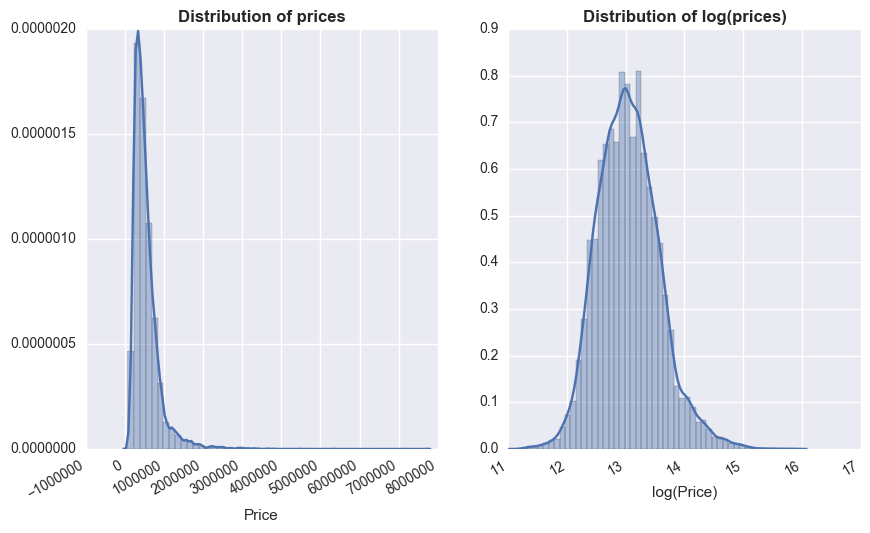

In [8]:
# Distribution of price value
plt.figure(figsize=(12,4))
fig, ax = plt.subplots(2)

# price
plt.subplot(121)
sns.distplot(data.price)
annotate("Distribution of prices", "Price")

# log(price)
plt.subplot(122)
sns.distplot(np.log(data.price))
annotate("Distribution of log(prices)", "log(Price)")

fig.autofmt_xdate()
plt.show()

Distribution of *price* is **right-skewed, with a long right tail** - as expected for this kind of financial data. Taking *log(price)* yields a bell shaped distribution. In the **predictive modeling** that follows we use the former, unaltered response variable. There are two reasons for it:

* Taking log(price) would mean that the higher the price, the lower is the loss due to an error per \$1. Here we assume that an error of \$1 has the same impact on the loss function independent of the house value.
* We focus on ensemble models based on trees, where the impact of this shape of the distribution is limited.

In the last part of this analysis we apply a **statistial approach** to analyze the data. There using *log(price)* is recommended to obtain good model fit and meaningful confidence intervals that are centered on expected mean values.

#### Predictors

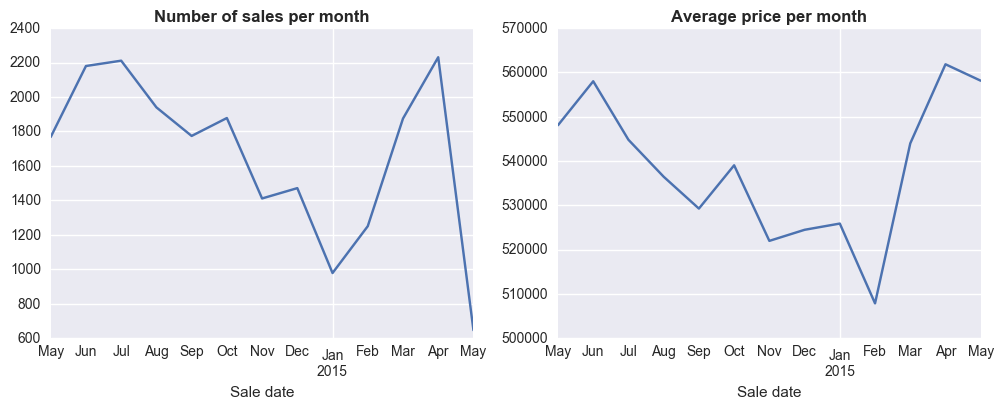

In [9]:
# setting price date as index
tmp_index = data.index
data.index = price_date

# Number of sales and average price over time
plt.figure(figsize=(12,4))
sale_value_monthly = data.price.groupby(pd.TimeGrouper(freq='M')).sum()
sale_count_monthly = data.price.groupby(pd.TimeGrouper(freq='M')).count()

# number of sales
plt.subplot(121)
sale_count_monthly.plot()
annotate("Number of sales per month", "Sale date")

# average value of sales
plt.subplot(122)
sale_value_monthly.divide(sale_count_monthly).plot()
annotate("Average price per month", "Sale date")

plt.show()

# restoring the index
data.index = tmp_index

The sales took place between **May 2015 and May 2016**. We see some **seasonality** in the data - there seem to be months with high high/low volume and respectively high/low average level of prices. Extrapolating from just one year is very risky, still we will do it for the sake of obtaining nice model fit. One should be cautious when extending this model to other years.

In the analysis we will use **only month variable in modeling**. Using date variable directly would make the model applicable only to the time period it was trained at, and that would make it unpractical.

In [10]:
# Construcion date range
print("Build date range: %d - %d" %(data.yr_built.min(), data.yr_built.max()))

Build date range: 1900 - 2015


Because the *build date* range is over 100 times longer than the *sale date* range, we will not introduce *age* variable (*sale date* - *build date*), and **just use *built year* variable**. Adding *age* would not bring additional information.

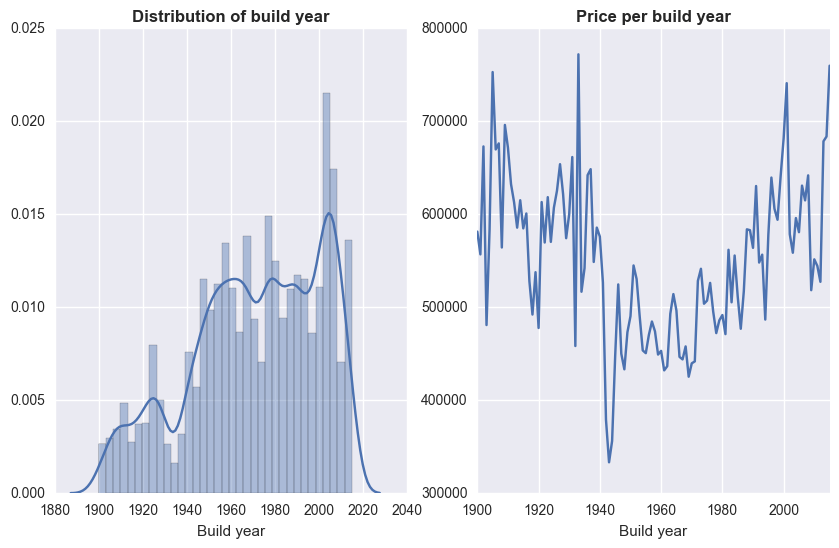

In [11]:
# build year distribution
plt.subplot(121)
sns.distplot(data.yr_built)
annotate('Distribution of build year','Build year')

# price per build year
plt.subplot(122)
data.groupby('yr_built').price.mean().plot()
annotate('Price per build year','Build year')

plt.show()

Most of the houses were built after II World War, and relatively many in years 2000 - 2010. Apparently houses built during the war periods (I and especially II World War) tend to be valued lower. Also the average prices of houses built before 1940 is relatively high, without any noticable trend, while the average price for houses built after 1960 displays an upward tendency.

Here however **we do not account for the impact of other predictors** - this pattern can be potentially explained by other predictors if the houses built during that time have different characteristics that are reflected in the dataset.

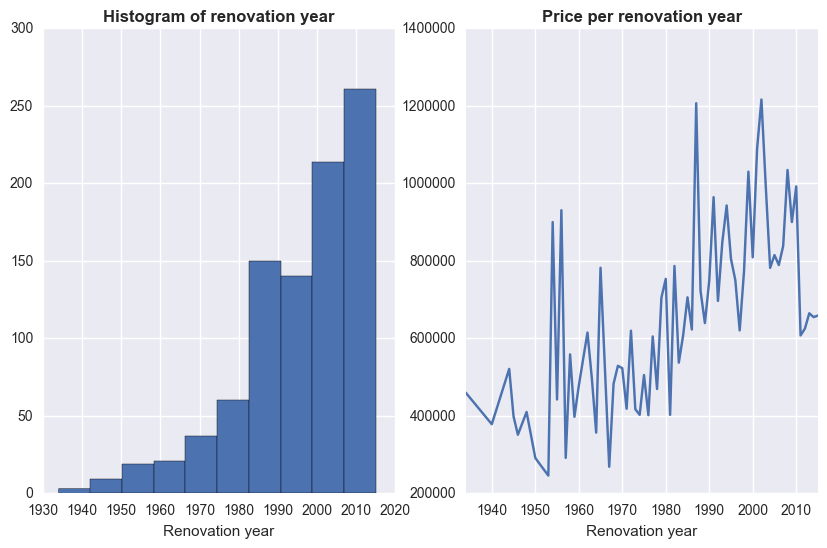

In [12]:
# year of renevation
plt.subplot(121)
data.yr_renovated[data.yr_renovated>0].hist()
annotate('Histogram of renovation year', 'Renovation year')

# price per year of renovation
plt.subplot(122)
data[data.yr_renovated>0].groupby('yr_renovated').price.mean().plot()
annotate('Price per renovation year', 'Renovation year')

plt.show()

Most *renovations* took place after year 1980, and **the more recent the *renovation*, the higer the *price* ** tends to be. This efect may be related to a similar trend present in the figure showing relation between average *price* and *contruction year*.

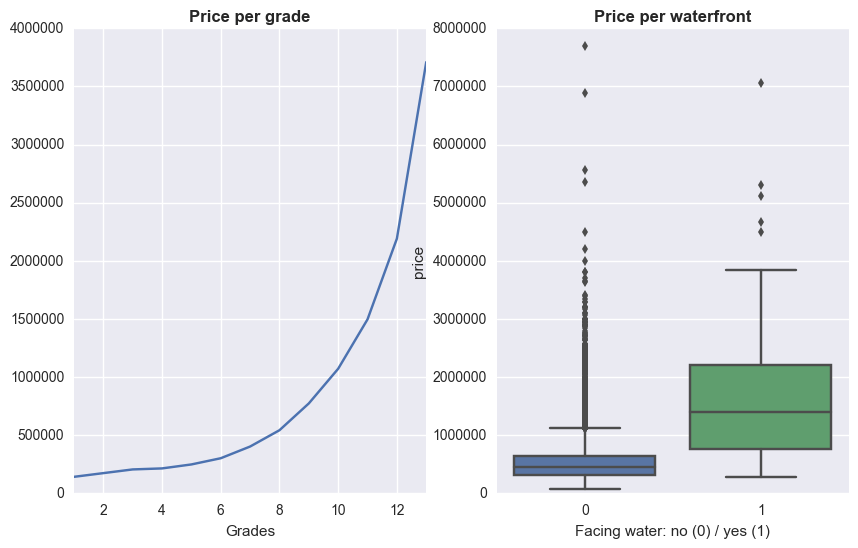

In [13]:
# grade variable
plt.subplot(121)
data.groupby('grade').price.mean().plot()
annotate('Price per grade','Grades')

# waterfront variable
plt.subplot(122)
sns.boxplot(data.waterfront, data.price)
annotate('Price per waterfront','Facing water: no (0) / yes (1)')

plt.show()

Both *Grade* and *waterfront* variables look promising as potential predictors.

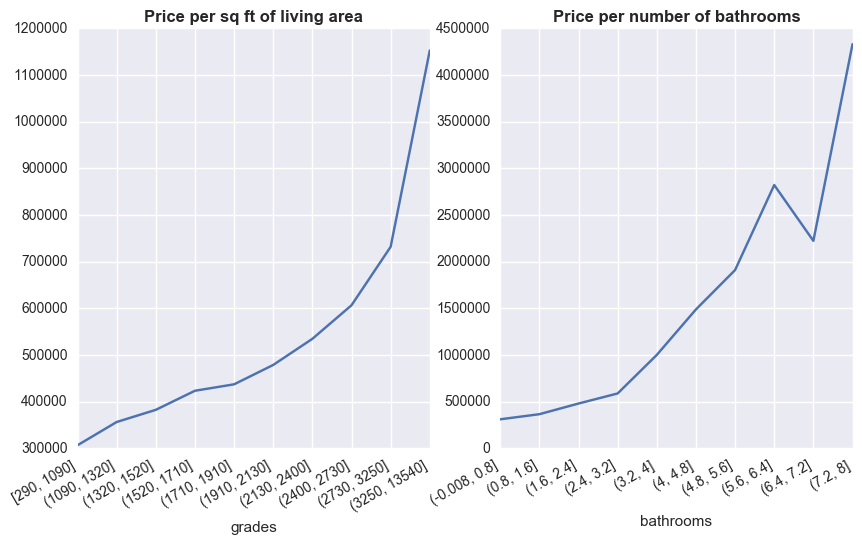

In [14]:
fig = plt.figure()

# sq ft of living area
plt.subplot(121)
plot_per_quantile('sqft_living', fig=fig)
annotate('Price per sq ft of living area', 'grades')

# price per number of bathrooms
plt.subplot(122)
plot_per_bin('bathrooms', fig=fig)
annotate('Price per number of bathrooms', 'bathrooms')

plt.show()

Also *sqft_living* and *bathrooms* shows strong correlation with the price. However one should note that such variables as *living area*, number of *bathrooms* or *bedrooms*, *basement area* can be strongly **correlated** - this should be kept in mind when trying to make inferences from our model (e.g. to decide contributions of particular variables into the price). For predictive modelling we can refer back to this fact in case of facing problems with high variance.

In [15]:
# Latitude and longitude
print('Latitude: %.3f, %.3f' % (data.lat.min(), data.lat.max()))
print('Longitude: %.3f, %.3f' % (data.long.min(), data.long.max()))

Latitude: 47.156, 47.778
Longitude: -122.519, -121.315


*Latitude and longitude* indicate all houses are located in or close to **Seattle, US**.

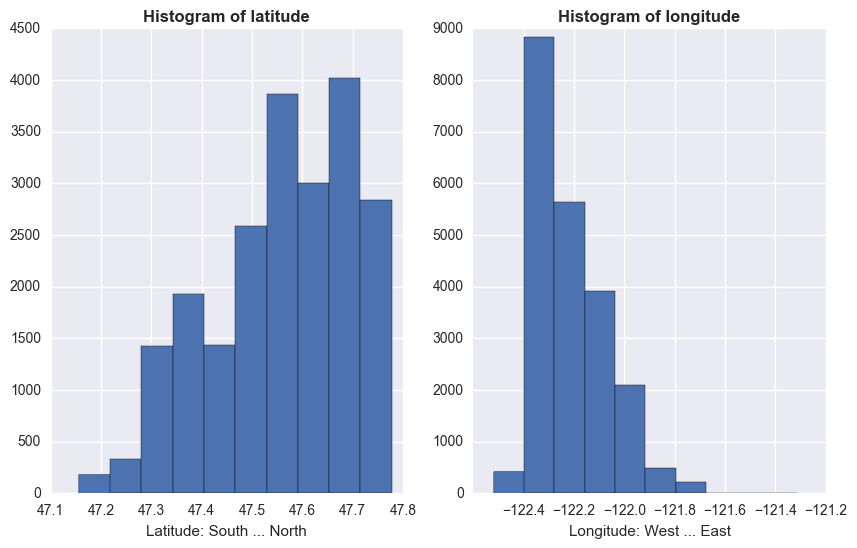

In [16]:
# Latitude
plt.subplot(121)
data.lat.hist()
annotate('Histogram of latitude', 'Latitude: South ... North')

# Longitude
plt.subplot(122)
data.long.hist()
annotate('Histogram of longitude', 'Longitude: West ... East')

plt.show()

Most houses are located to the north - where the center of Seattle lies - and to the west - large mountaineus area to the east and a bay in the extreme west part of the sampled area can be easly noted.

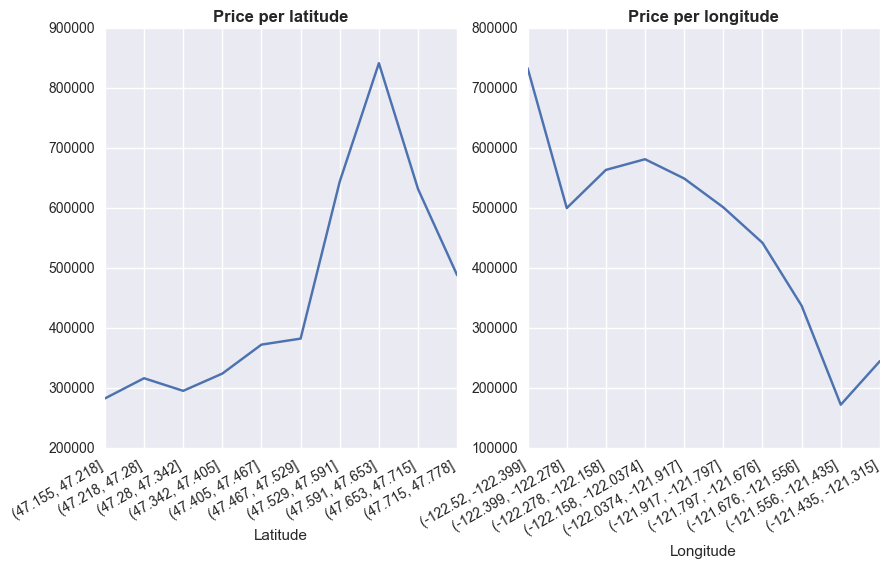

In [17]:
fig = plt.figure()

# price per latitude
plt.subplot(121)
plot_per_bin('lat', fig=fig)
annotate('Price per latitude', 'Latitude')

# price per longitude
plt.subplot(122)
plot_per_bin('long', fig=fig)
annotate('Price per longitude', 'Longitude')

plt.show()

House prices per location change similarly to the distribution of houses being sold. One exception is the bay area at the extreme west where there are relativelly few houses being sold while maintaing high prices.

## Preprocessing
The data set contains a few variables that apparently bring not much additional information (*sqft_living15, sqft_lot15* related to *sqft_living, sqft_lot*, and *yr_renovated* due to high share of missing values). Some variables identify a particular geographical area (*zipcode, lat, long*). However **non of these are false predictors** - all of them are available whenever a house is put on sale (e.g. its location) and so should be utilized in practical application. One could address **correlation between predictors** as a potential source of increased variability of the model - we skip that part now and refer back to it in the Statistical Approach section towards the end of the report. For our predictive modelling **we will use the full set of available variables**.

Following **preprocessing** is done:

* dropping *id* and *price* (identifier and response)
* transforming *date* of sale into *month* dummies and dropping date
* transforming *zipcode* into dummies
* *yr_built* is left (it is not transformed into *age* variable as explained above)

**Response variable is left unchanged**, with its right-skewed distribution, as explained above (we want to value an equal error in \$ the same, irrespective whether it is made for a cheap or an expensive house).

In [18]:
# variables to drop if utilizing just 16 of them
drop0 = ['id','price','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15']

# variables to drop if utilizing the full set of variables
drop1 = ['id','price']

def transform_predictors(raw_data):
    """
    id, price -> drop
    date -> month dummies
    zipcode -> zipcode dummies
    """
    X = raw_data.drop(drop1, axis=1)
    month = X.date.apply(pd.to_datetime).apply(lambda x: x.month)
    X = pd.concat([X, pd.get_dummies(month, 'm')], axis=1)
    X = X.drop('date', axis=1)
    X = pd.concat([X, pd.get_dummies(X.zipcode, 'z')], axis=1)
    X = X.drop('zipcode', axis=1)
    return X

def random_subset(p, data):
    """
    Select a subset of data.
    
    This is useful for experimenting with models that do not display much gain
    when increasing the size of the sample (e.g. linear regression models).
    """
    n_rows = data.shape[0]
    rows_selection = bernoulli.rvs(p, size=n_rows).astype('bool')
    return data[rows_selection]

In [19]:
sub_data = data # use full dataset
X = transform_predictors(sub_data) # preprocessing predictors
y = sub_data.price # unchanged response variable
n_samples, n_features = X.shape
features = X.columns

## Cross-validation
We randomly split the dataset into **train (70%) and test (30%)**. We use **cross-validation on the train set to evaluate and select models**. To obtain unbiased estimation of **the generalization error we evaluate models on the test set**. Thus the test set estimates are not used for model selection.

The evaluation measure is the **coefficient of determination $R^2$**, **learning curve** is used to diagnosed model and decide on the next steps.

For the test set apart from the $R^2$ we also display the **root of the mean squared error** and **mean absolute error**. The last of the these measures can be considered as showing the estimated average error in \$ made be the model. We also **visualize model predictions quality** by overplotting the actual house prices with predicted prices (sorted by the actual price).

In [20]:
# Test-Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
n_train = y_train.shape[0]
n_test = y_test.shape[0]

# Cross validation - will be used to evaluate the models using train data
kf = KFold(n_splits=3, random_state=234)

In [21]:
def cv_evaluate(est, cv, X_train, y_train):
    """
    Evaluation using cross-validation
    
    Displays the coefficient of determination.
    Plots the learning curve.
    """
    cv_scores = cross_val_score(est, X_train, y_train, cv=cv, n_jobs=2)
    cv_score = cv_scores.mean()
    print("CV Coefficient of determination R\u00b2: %.3f" % cv_score)
    
    # Learning curve
    train_sizes, train_scores, valid_scores = learning_curve(
            est, X_train, y_train, cv=cv)
    
    # Plotting the learning Curve
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = valid_scores.mean(axis=1)
    plt.figure()
    plt.ylim((.5,1))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.axhline(y=cv_score.mean(), color='black', lw=1, linestyle='--', label="CV score using all data")
    plt.title("Learning Curve", fontweight='bold')
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()
    
def test_evaluate(est, X_test, y_test, log=False):
    """
    Test set evaluation
    
    Displays three evaluation measures
    Plots actual and fitted prices
    """
    # prediction
    pred = est.predict(X_test)
    
    # scoring
    test_score = r2_score(y_test, pred)
    print("Test Coefficient of determination R\u00b2: %.3f" % test_score)
    if log:
        mse = mean_squared_error(np.exp(y_test), np.exp(pred))
        mae = mean_absolute_error(np.exp(y_test), np.exp(pred))
    else:
        mse = mean_squared_error(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
    print("Root mean squared error: %.3f" % mse**.5)
    print("Mean absolute error: %.3f" % mae)
    
    # plotting the predictions
    n = y_test.shape[0]
    plt.plot(np.arange(n),y_test.iloc[y_test.argsort()], c='red', lw=1, label="Actual price")
    plt.scatter(np.arange(n),pred[y_test.argsort()], s=5, alpha=1., c='black', label="Predicted price")
    if log:
        annotate("Actual and predicted log(prices)", "Houses sorted per actual price", "log(price)")
    else:
        annotate("Actual and predicted prices", "Houses sorted per actual price", "Price")
    plt.legend(loc="best")
    plt.show()

## Predictive Models
We fit four models:

1. Linear Regression
2. KNN Regression
3. Random Forest Regression
4. XGBoost Regression (Boosted Trees)

### Linear Regression
To obtain a good fit and reasonable inferences we should first:

1. take the log of the reponse variable
2. remove collinearity between variables

We skip the first point for reasons explained above (under the plot of response variable distribution), and the second one for simplicity. We come back the these issues in the last part of this analysis when applying statistical approach.

In [22]:
# Model fitting
lr = LinearRegression()
lr.fit(X_train, y_train)

# The coefficients
# print(pd.Series(lr.coef_, index=features))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

CV Coefficient of determination R²: 0.799


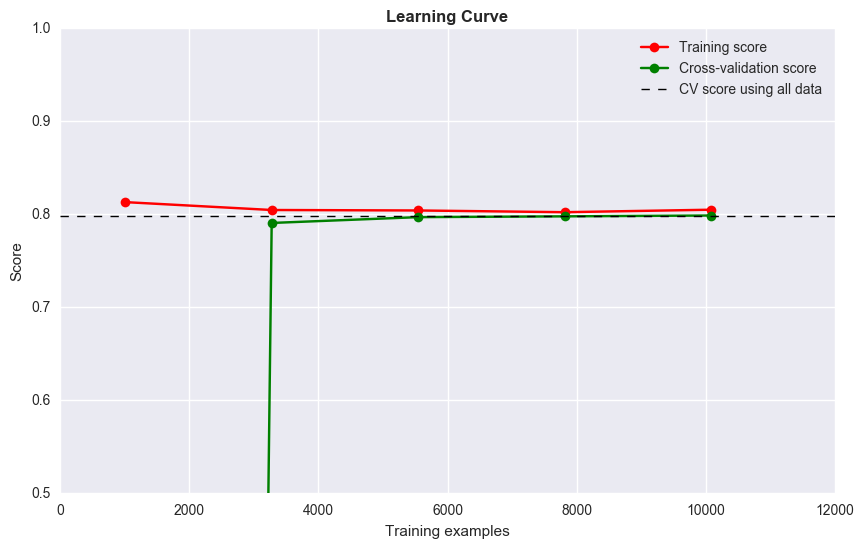

In [23]:
# Evaluation using CV
cv_evaluate(lr, kf, X_train, y_train)

**We need more flexible model** as this model obtains its maximum quality of fit when trained at just 40% of available data. It displays strong bias, and relaxing the model is necessary.

Test Coefficient of determination R²: 0.821
Root mean squared error: 155795.900
Mean absolute error: 95090.994


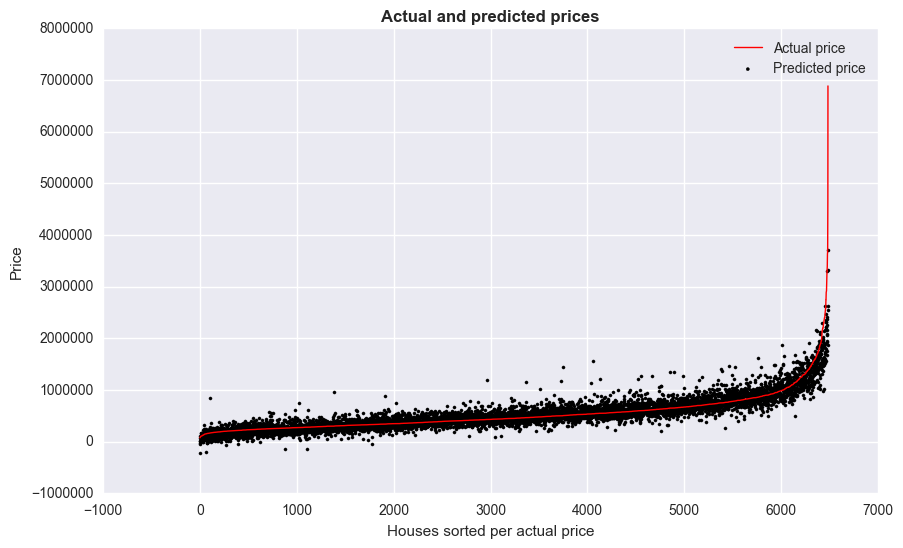

In [24]:
# Evaluation on the test set
test_evaluate(lr, X_test, y_test)

The test set evaluation of the generalization error is surprisingly high (0.821). We also see that the model could be slightly improved by bounding the response to be positive.

### KNN Regression
KNN model uses a measure of distance between observations and so the predictors are standardized before fitting the model.

In [25]:
# Model fitting
knn_pipe = make_pipeline(
        StandardScaler(),
        KNeighborsRegressor(n_jobs=7, n_neighbors=6))
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=7, n_neighbors=6, p=2,
          weights='uniform'))])

CV Coefficient of determination R²: 0.727


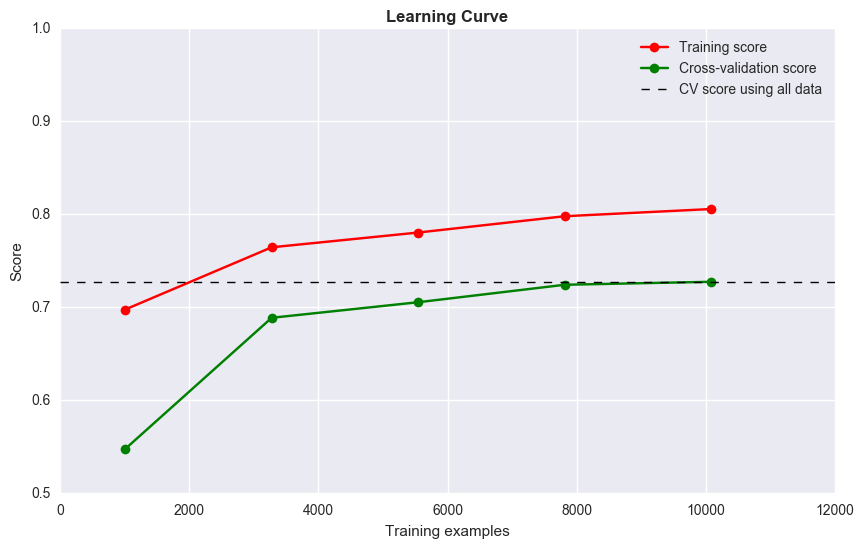

In [26]:
# Evaluation using CV
cv_evaluate(knn_pipe, kf, X_train, y_train)

KNN fares badly, achieving a score of just 0.727. It suggests that housing prices are **not strongly driven by similarity between the buildings**. Quite similar houses (in terms of our predictors) may have much different prices. **To account for this we fit models based on tree ensembles** in the next sections.

We could try to fix KNN model by closing the gap between training score and CV score but there is no chance for it to exceed the prerformance of a linear regression model.

Test Coefficient of determination R²: 0.774
Root mean squared error: 175161.689
Mean absolute error: 101666.599


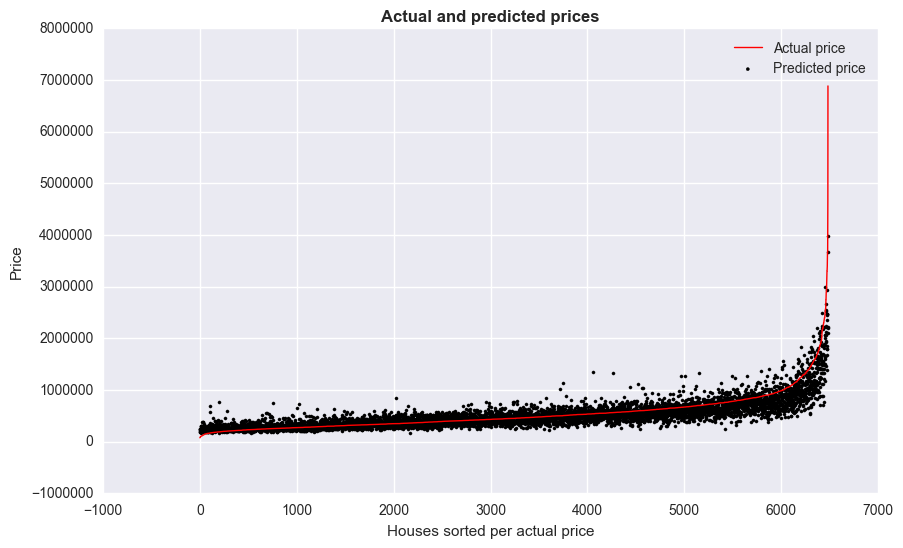

In [27]:
# Evaluation on the test set
test_evaluate(knn_pipe, X_test, y_test)

### Random Forest
We fit random forest model with **50 basic estimators** and otherwise default values for the parameters (one may want to optimize their values using *grid search*).

In [28]:
# Model fitting
rf = RandomForestRegressor(n_jobs=2, n_estimators=50, random_state=123)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=2, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

CV Coefficient of determination R²: 0.870


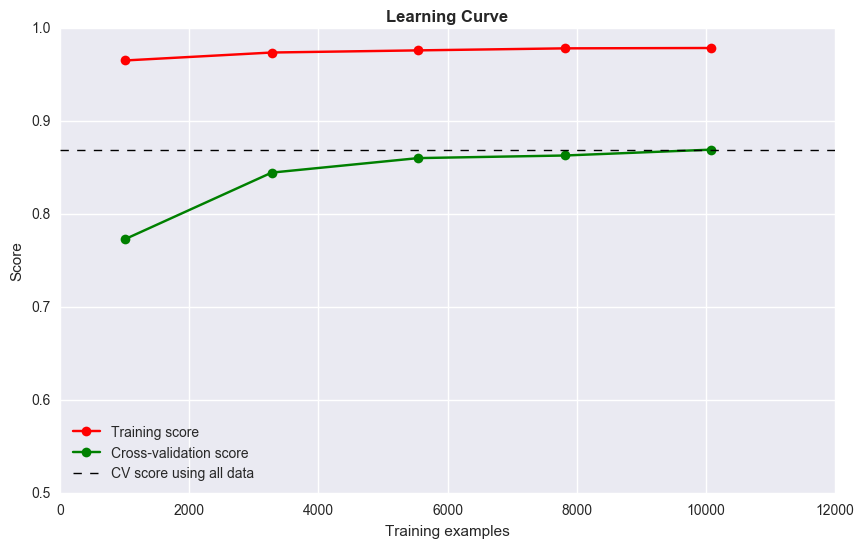

In [29]:
# Evaluation using CV
cv_evaluate(rf, kf, X_train, y_train)

Random forest turns out to be **the best model so far** with $R^2$ of 0.870. There's a large gap between train error and cv error lines. In the next section we fit boosted tress model with build-in regularization to **try to close this gap and increase the final cv error**.

Test Coefficient of determination R²: 0.882
Root mean squared error: 126323.545
Mean absolute error: 69405.736


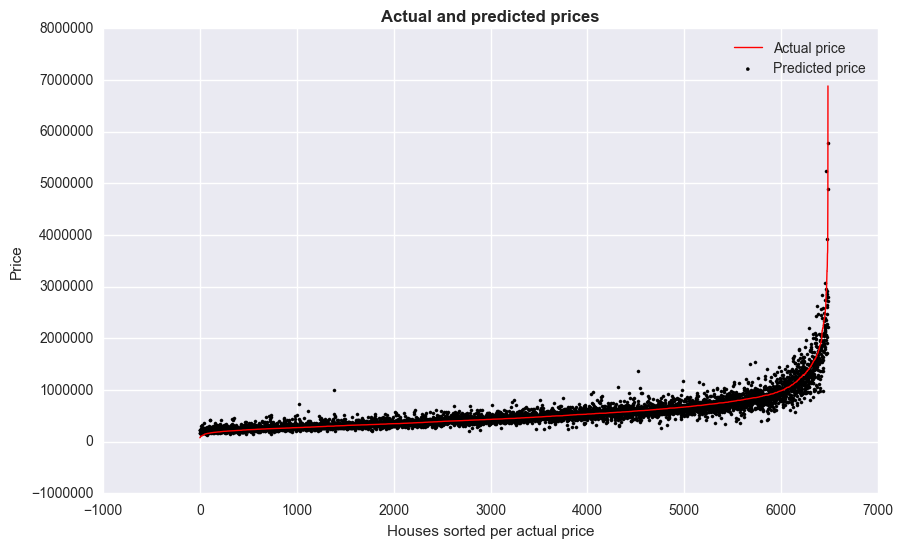

In [30]:
# Evaluation on the test set
test_evaluate(rf, X_test, y_test)

The test set evaluation suggest the estimated average error of the model is around $69,000.

In [31]:
# Feature importances
table = pd.concat([pd.DataFrame(X_train.columns, columns=['Predictors']),
           pd.DataFrame(rf.feature_importances_, columns=['Importance'])],
    axis=1)
table.sort_values(by='Importance', ascending=False)[:10]

,Predictors,Importance
8,grade,0.296615
2,sqft_living,0.280091
13,lat,0.159831
14,long,0.065612
15,sqft_living15,0.031224
5,waterfront,0.026921
11,yr_built,0.026639
9,sqft_above,0.022745
16,sqft_lot15,0.013517
6,view,0.013114


The features importances table shows that **the grade, the living area of the house, and its location** (especially its position on the north-south axis) contribute most to its price.

### XGBoost Regression
We fit the XGB Regressor with deafult settings - again we could try to improve the prediction quality using *grid search* to optimize its parameters.

In [89]:
# Model fitting
xgb = XGBRegressor(nthread=2, seed=123)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=2,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=1)

CV Coefficient of determination R²: 0.865


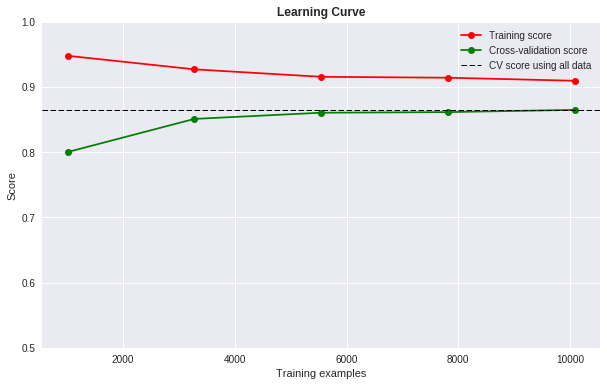

In [90]:
# Evaluation using CV
cv_evaluate(xgb, kf, X_train, y_train)

XGB model closed a bit the gap between training and cross-validation errors, however **failed the increase the CV score** comparing with the random forest model. Still the CV scores for the two models are **relatively similar** (0.870 and 0.865).

Test Coefficient of determination R²: 0.881
Root mean squared error: 127051.413
Mean absolute error: 75618.113


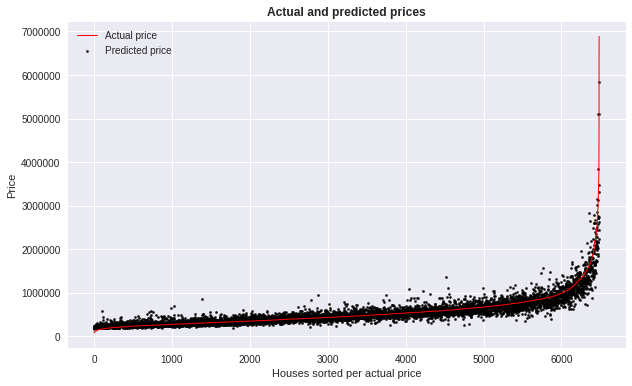

In [91]:
# Evaluation on the test set
test_evaluate(xgb, X_test, y_test)

In [92]:
# Feature importances
table = pd.concat([pd.DataFrame(X_train.columns, columns=['Predictors']),
           pd.DataFrame(xgb.feature_importances_, columns=['Importance'])],
    axis=1)
table.sort_values(by='Importance', ascending=False)[:10]

,Predictors,Importance
13,lat,0.172965
2,sqft_living,0.114826
8,grade,0.079942
14,long,0.072674
11,yr_built,0.066860
15,sqft_living15,0.062500
3,sqft_lot,0.055233
9,sqft_above,0.050872
5,waterfront,0.040698
6,view,0.034884


The order of importance of predictors is different than for random forest model, however the lists are quite similar, e.g. the same 3 variables appear at the top of both lists.

## Statistical approach
We apply **linear regression model**. The response variable is transformed to make it conform to a bell-shape distribution. This approach can be **refined and extended** in different directions, e.g. it can be used to identify individual relationships between predictors and the reponse or make other kinds of inferences.

### Data preparation
Response variables is *log(price)*, the predictors are prepared in a form suitable for analysis using *statsmodels* package. The model is fitted on 70% of available data.

In [32]:
def statsmodels_transform(raw_data):
    """
    id, price -> drop
    date -> month objects
    zipcode -> zipcode objects
    """
    X = raw_data.drop(drop1, axis=1)
    X['month'] = X.date.apply(pd.to_datetime).apply(lambda x: x.month).astype('object')
    X = X.drop('date', axis=1)
    X['zip'] = X.zipcode.astype('object')
    X = X.drop('zipcode', axis=1)
    return X

y = np.log(data.price)
X = statsmodels_transform(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
n_train = y_train.shape[0]
n_test = y_test.shape[0]
y_train.name = 'log_price'
y_test.name = 'log_price'

### Linear Regression
We **fit the model**, run some **diagnostics** and make a small investigation concerning **the impact of *construction year* on the *price* **.

#### Model fitting

In [33]:
# Model fitting using all variables
predictors = '+'.join(X_train.columns)
formula = '~'.join([y_train.name, predictors])
table = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
ols = smf.ols(formula, data=table)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     1137.
Date:                Tue, 13 Jun 2017   Prob (F-statistic):               0.00
Time:                        22:37:14   Log-Likelihood:                 4286.0
No. Observations:               15129   AIC:                            -8378.
Df Residuals:                   15032   BIC:                            -7638.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       -64.7725      7.982     -8.115

The output of the model allows us to evaluate the **impact of individual predictors** (i.e. keeping other predictors fixed). We can note some interesting facts:

* majority of the zip codes are significant
* months can be divided into those of increased prices (Feb-May) and decreased prices (Sep-Nov)
* the number of bedrooms doesn't seem important for the price
* prices are higher towards north-west, and lower towards south-east
* facing water has strong positive impact on the price - most probably it refers to houses built around the bay at the western edge of the area covered by the dataset
* price increases with the area of the house, but decreases with the number of floors

Still, caution is suggested - e.g. the insignificance of the number of bedrooms may be a result of it being correlated with the total area of the house and the number of bathrooms; or it the impact of the number of bedrooms could be actually nonlinear (say too few or too many both tend to lower the price). 

#### Model diagnostics

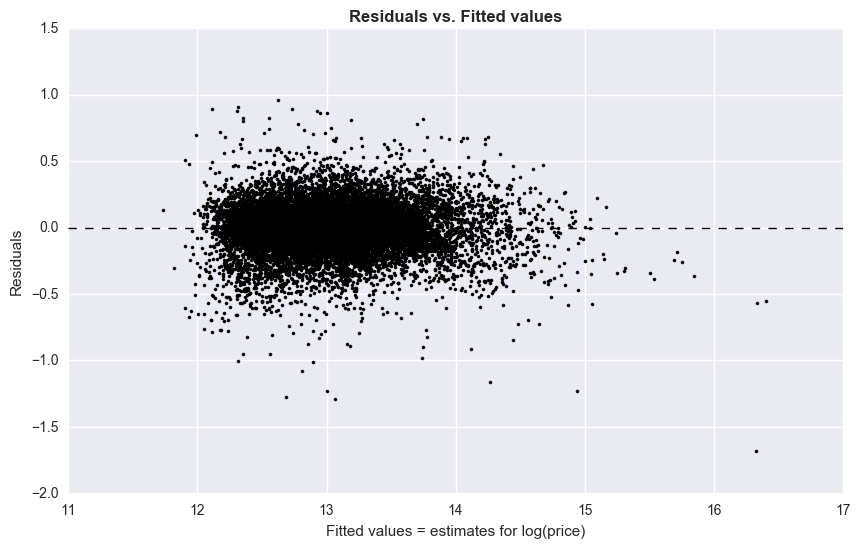

In [34]:
# Residual plot
fitted = results.fittedvalues
order = fitted.argsort()
plt.axhline(y=0, color='black', lw=1, linestyle='--')
plt.scatter(fitted.iloc[order], results.resid.iloc[order], s=5, alpha=1., c='black')
annotate('Residuals vs. Fitted values', 'Fitted values = estimates for log(price)', 'Residuals')
plt.show()

The residuals display **no pattern**.

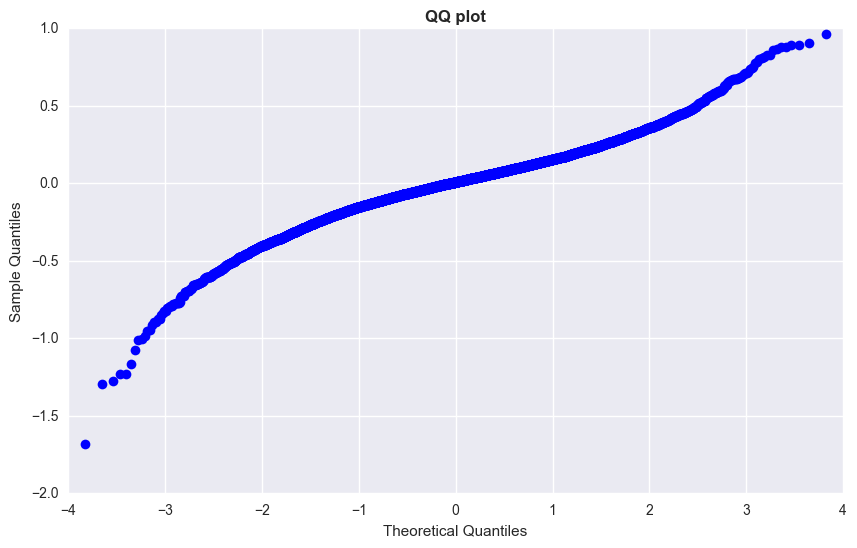

In [35]:
# QQ plot
qqplot(results.resid)
plt.title('QQ plot', fontweight='bold')
plt.show()

The QQ plot indicates the distribution of errors has **tails heavier** than the normal distribution.

The model indicates problems with **collinearity** between variables. Collinearity increases actual variance of the predictions so should be avoided. We can deal with that problem by eliminating correlated variables, or replacing them with a single feature (e.g. using PCA). The **correlation heatmap** shows a few highly correlated variables (mostly related to measures of different areas of the houses).

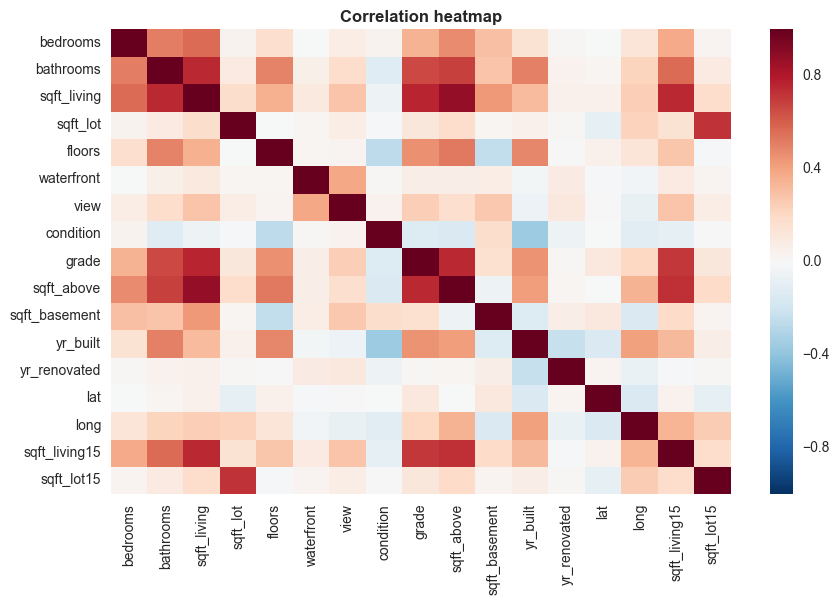

In [36]:
# correlation heatmap
corr = X_train.drop(['month','zip'], axis=1).corr()
sns.heatmap(corr)
plt.title('Correlation heatmap', fontweight='bold')
plt.show()

Alternatively we can use **variance inflation factors** to identify collinear variables.

In [37]:
def vif_table(columns, X):
    vif = [variance_inflation_factor(X[columns].values, i) for i in np.arange(len(columns))]
    return pd.Series(vif, index=columns)

print(vif_table(X_train.columns.drop(['month','zip']), X_train))

bedrooms         2.265388e+01
bathrooms        2.836544e+01
sqft_living               inf
sqft_lot         2.390966e+00
floors           1.671948e+01
waterfront       1.194061e+00
view             1.530213e+00
condition        3.476201e+01
grade            1.427929e+02
sqft_above                inf
sqft_basement             inf
yr_built         8.563062e+03
yr_renovated     1.190641e+00
lat              1.206742e+05
long             1.342776e+05
sqft_living15    2.637449e+01
sqft_lot15       2.593598e+00
dtype: float64


Test Coefficient of determination R²: 0.881
Root mean squared error: 160533.491
Mean absolute error: 75996.727


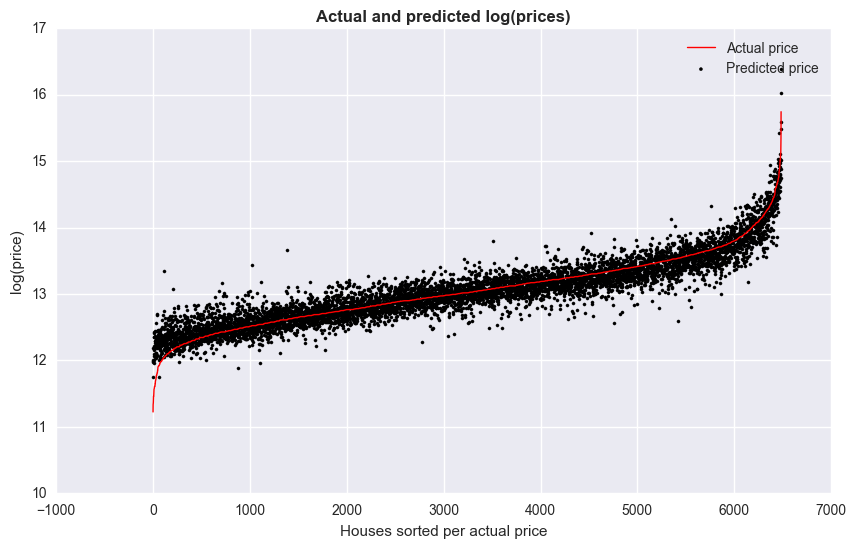

In [38]:
# Evaluation on the test set
test_evaluate(results, X_test, y_test, log=True)

The model shows high $R^2$ of 0.881, though this is calculated for prices put on a log scale. Still the estimated average loss per transactions is very low, \$76,000.

#### Impact of the construction year on the price

We try to **identify the impact of *construction year* on the house *price* **, by removing the impact of all the other variables on the *log(price)* and checking the distribution of residuals conditional on the construction year.

In [100]:
# Model fitting using all variables except yr_built
predictors = '+'.join(X_train.columns.drop('yr_built'))
formula = '~'.join([y_train.name, predictors])
table = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
results = smf.ols(formula, data=table).fit()

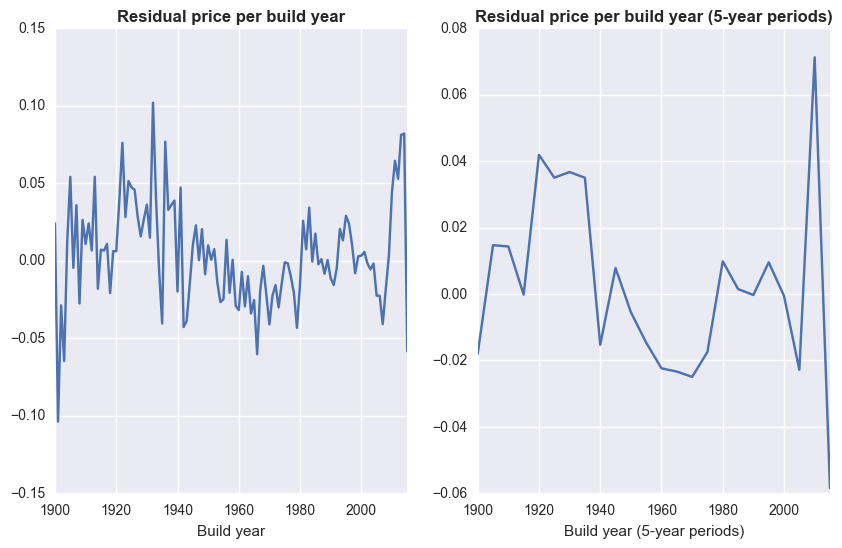

In [39]:
# residual price per built year
plt.subplot(121)
results.resid.groupby(X_train.yr_built).mean().plot()
annotate('Residual price per build year', 'Build year')
# residual price per built year aggregated into 5-year periods
plt.subplot(122)
period = X_train.yr_built.apply(lambda x: 5*(x//5))
results.resid.groupby(period).mean().plot()
annotate('Residual price per build year (5-year periods)', 'Build year (5-year periods)')
plt.show()

The plots shows that - assuming our model is correct - the **houses built between the two World Wars are valued significantly more**, than should be expected from their other features (like area, view etc.). Also the **buildings built during 1960's and 1970's are valued significantly less**. The **youngest houses (built in 2010 - 2014) tend to have the highest relative value**.

## Summary
The predictive analysis yields two good models: the best one is **random forest**, closely followed by **XGB regressor**, with estimated generalization **$R^2$ of 0.882 and 0.881** respectively, and **mean absolute error of \$69,000 and \$76,000** respectively.

Possible improvement could be made by **optimizing model parameters** (e.g. using *grid search*), building **ensemble of the models** (e.g. taking an average of predictions or training a higher level model on cross-validated predictions of the base models), or experimenting with other models (testing, and possibly including in an ensemble).

The statistical approach creates a model with a good **mean absolute error of \$76,000** and while allowing for making inferences about the impact of individual predictors.

Concerning the impact of *construction year on the price* it is concluded that the **price tends to be highest for the youngest buildings** (constructed in 2010-2014) and **relatively high for buildings constructed between the two Word Wars**. On the other end, **houses build in 1960's and 1970's are relatively undervalued**.